# [Survival Analysis](https://en.wikipedia.org/wiki/Survival_analysis)

from : https://www.pymc.io/projects/examples/en/latest/survival_analysis/survival_analysis.html

## Theory

If the random variable $T$ is the time to the event we are studying, survival analysis is primarily concerned with the survival function: 
$$
S(t) = Pr(T > t) = 1 - F(t)
$$

Where $F(t)$ is the cumulative distribution function of $T$.

The survival function is the probability that the event will occur by time $t$ and is express in terms of [hazard rate](https://en.wikipedia.org/wiki/Survival_analysis#Hazard_function_and_cumulative_hazard_function), $\lambda(t)$, which is the instantaneous probability that the event will occur by time $t$ given that it has not already occurred by time $t$.

$$
\lambda(t) = \lim_{\Delta t \to 0} \frac{Pr(t < T > t + \Delta t | T > t)}{\Delta t}
$$

Which can be simplified to
$$
\lambda(t) = \frac{S'(t)}{S(t)}
$$

Solving this differential equation for the survival function shows that:

$$
S(t) =  exp(-\int_0^t \lambda(s) ds)
$$

This representation of the survival function shows that the cumulative hazard function is:

$$
\Lambda(t) = \int_0^t \lambda(s) ds
$$

An important, but subtle, point in survival analysis is [censoring](https://en.wikipedia.org/wiki/Survival_analysis#Censoring). 

## Bayesian proportional hazards model
Perhaps the most commonly used risk regression model is [Cox’s proportional hazards model(https://en.wikipedia.org/wiki/Proportional_hazards_model)]. In this model, if we have covariates $x$ and regression coefficients $\beta$, the hazard rate is modeled as :

$$
\lambda(t) = \lambda_0(t)exp(x\beta)
$$

Here $\lambda_0(t)$ is the baseline hazard rate which is independent of the covariates $x$.
In order to perform Bayesian inference with the Cox model, we must specify priors on $\beta$ and $\lambda_0(t)$:
$$\beta \sim N(\mu_\beta, \sigma^2_\beta)$$
$$\mu_\beta \sim Nomral(0, 10^2)$$ 
$$\sigma^2_\beta \sim Uniform(0,10)$$

$\lambda_0(t)$ is set as a semiparametric prior, a constant function, which require to partition the time range into intervals. This requires to choose priors for the $N-1$ intervals $\lambda_j$. $\lambda_j$ is usually a [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution) or a [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution).


The key observation is that the piecewise-constant proportional hazard model is closely related to a Poisson regression model. (The models are not identical, but their likelihoods differ by a factor that depends only on the observed data and not the parameters $\beta$ and $\lambda_j$.
We define indicator variables based on whether the $i$-th subject died in the $j$-th interval:

$$
d_{ij} = \begin{cases} 
1 & \text{if subject } i \text{ died in interval } j, \\
0 & \text{otherwise.}
\end{cases}
$$

We also define $t_{i,j}$ to be the amount of time the $i$-th subject was at risk in the $j$-th interval.


## Code

In [1]:
import os
import sys
import numpy as np
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)

from BI import bi,jnp
# Setup device------------------------------------------------
m = bi(platform='cpu')

# Import Data & Data Manipulation ------------------------------------------------
data_path = os.path.dirname(os.path.abspath("")) + "/BI/resources/data/"
m.data(data_path +'mastectomy.csv', sep=',') # Import

m.df.metastasized = (m.df.metastasized == "yes").astype(np.int64)
m.df.event = jnp.array(m.df.event.values, dtype=jnp.int32)
m.models.survival.surv_object(time='time', event='event', cov='metastasized', interval_length=1) # if interval = 3 we get the same as in PyMC notebook
m.data_on_model['metastasized']

jax.local_device_count 32


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:13<00:00, 71.83it/s, 511 steps of size 5.27e-03. acc. prob=0.97]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.77,0.50,-0.0,1.56,0.05,0.04,102.21,175.74,NaN
lambda0[0],0.00,0.00,0.0,0.00,0.00,0.00,135.10,93.09,NaN
lambda0[1],0.00,0.00,0.0,0.01,0.00,0.00,215.95,174.39,NaN
lambda0[2],0.00,0.01,0.0,0.01,0.00,0.00,276.17,205.81,NaN
lambda0[3],0.00,0.01,0.0,0.01,0.00,0.00,214.70,289.83,NaN
...,...,...,...,...,...,...,...,...,...
lambda0[71],0.00,0.01,0.0,0.00,0.00,0.00,120.72,27.43,NaN
lambda0[72],0.00,0.01,0.0,0.00,0.00,0.00,181.53,212.32,NaN
lambda0[73],0.00,0.01,0.0,0.00,0.00,0.00,77.63,85.77,NaN
lambda0[74],0.00,0.01,0.0,0.00,0.00,0.00,206.02,283.56,NaN


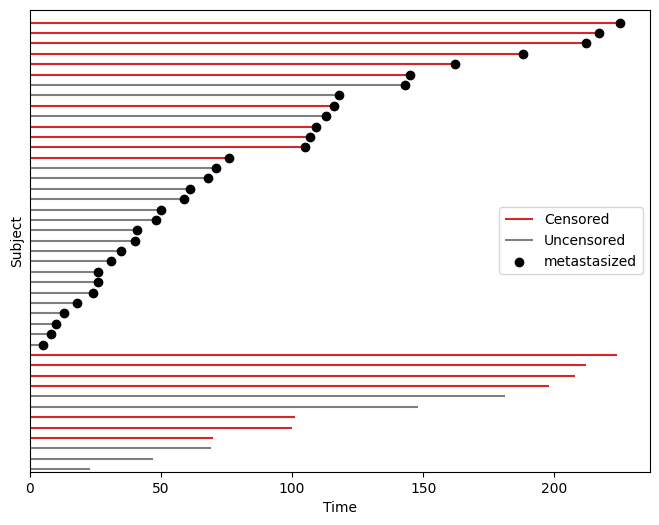

In [ ]:
import os
import sys
import numpy as np
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)

from BI import bi,jnp
# Setup device------------------------------------------------
m = bi(platform='cpu')

# Import Data & Data Manipulation ------------------------------------------------
data_path = os.path.dirname(os.path.abspath("")) + "/BI/resources/data/"
m.data(data_path +'mastectomy.csv', sep=',') # Import

m.df.metastasized = (m.df.metastasized == "yes").astype(np.int64)
m.df.event = jnp.array(m.df.event.values, dtype=jnp.int32)
m.models.survival.surv_object(time='time', event='event', cov='metastasized', interval_length=1) #! if interval = 3 we get the same as in PyMC notebook

# Plot censoring ------------------------------------------------
m.models.survival.plot_censoring(cov='metastasized')

# Model ------------------------------------------------
def model(intervals, death, metastasized, exposure):
    # Parameters priors distributions-------------------------
    ## Base hazard distribution
    lambda0 = m.dist.gamma(0.01, 0.01, shape= intervals.shape, name = 'lambda0')

    ## Covariate effect distribution
    beta = m.dist.normal(0, 1000, shape = (1,),  name='beta')

    ## Likelihood
    ### Compute hazard rate based on covariate effect
    #lambda_ = m.models.survival.hazard_rate(cov = metastasized, beta = beta, lambda0 = lambda0)
    lambda_ =jnp.outer(jnp.exp(beta * metastasized), lambda0)
    
    ### Compute exposure rates
    mu = exposure * lambda_

    # Likelihood calculation
    m.dist.poisson(mu + jnp.finfo(mu.dtype).tiny, obs = death)

m.fit(model, num_samples=500) 

m.summary()
#m.models.survival.plot_surv()

Alternatively, you can use the `m.models.survival.model` for the built in model. 

sample: 100%|██████████| 1000/1000 [00:40<00:00, 24.46it/s, 511 steps of size 4.92e-03. acc. prob=0.93]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
/home/sosa/.local/lib/python3.10/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/sosa/.local/lib/python3.10/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/sosa/.local/lib/python3.10/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this 

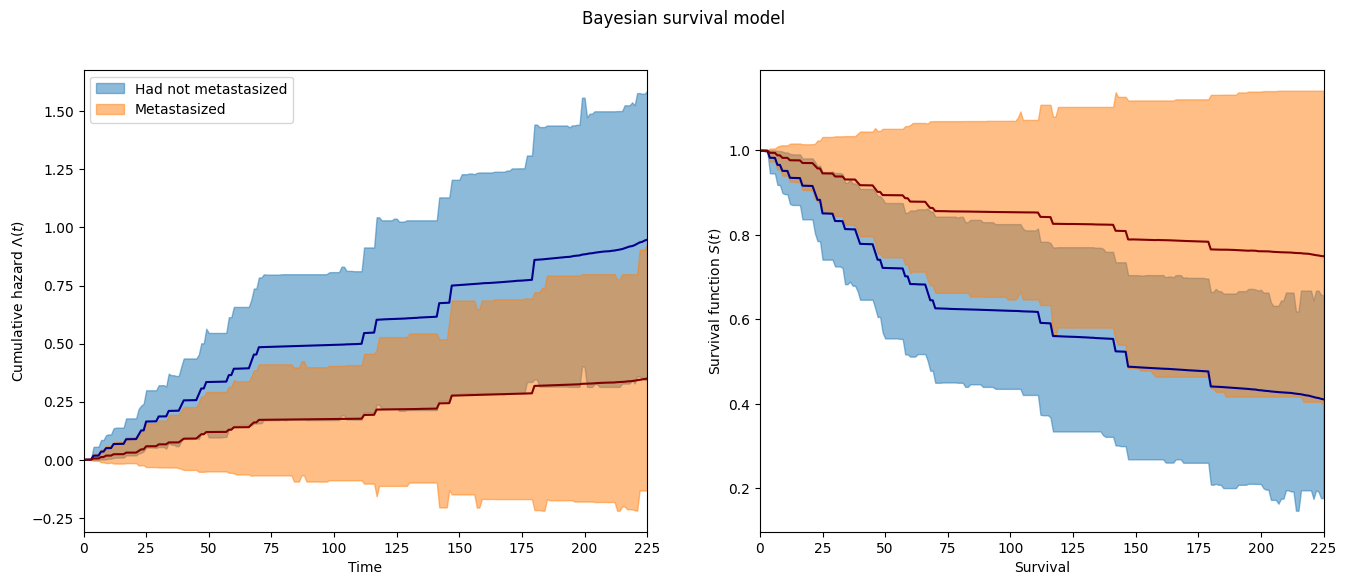

In [412]:
m.fit(m.models.survival.model, num_samples=500) 
m.summary()
m.models.survival.plot_surv()

# Testing new approach (similar to NBDA class)

We will create a 3D object (N,T,V), where N is the number of nodes, T is the number of time steps, and V is the number of variables. 

In [180]:
import jax
import jax.numpy as jnp
import numpy as np
# estimation will change because alphabetic names of prior generating different seed to get same resutls as PyMC, gange names of priors to 'lambda0', 'beta'
class surv:
    def __init__(self, time, event, interval_length = 1 ):
        self.n_patients = None
        self.patients = None
        self.time = None
        self.event = None
        self.cov = None
        self.interval_length = None
        self.interval_bounds = None
        self.n_intervals = None
        self.death = None
        self.exposure = None
        self.base_hazard = None
        self.met_hazard = None  
        self.data_on_model = {}
        self.cov_names = [] # Time-invariant covariates names
        self.cov = np.array([])  # Time-invariant covariates
        self.cov_v_names = []  # Time-varying covariates names
        self.cov_v = None  # Time-varying covariates 
        self.df = None
        self.oberved = None
        self.surv_object(time, event, interval_length)

    def surv_object(self, time, event, interval_length=1):
        """
        Convert data into of survival information into a surv object.
        Converts continuous time and event data into discrete time intervals for survival analysis if interval_length > 1.

        Parameters:
        -----------
        time : 1D jnp.ndarray of shape (N,) representing the continuous time variable.
        event : 1D Binary jnp.ndarray of shape (N,) representing the event indicator.
        interval_length : int, optional
            The length of each discrete time interval (default is 3).

        Returns:
        --------
        - n_patients : int
            Number of patients in the dataset
        - patients : np.array
            Array of patient indices
        - time : np.array
            Array of time points
        - event : np.array
            Array of event status
        - interval_bounds : jnp.ndarray
            Array of boundaries for discrete time intervals.
        - n_intervals : int
            The total number of discrete intervals.
        - intervals : jnp.ndarray
            Array of interval indices.
        - death : jnp.ndarray
            A binary matrix (n_patients x n_intervals) indicating whether each subject experienced the event
            in each interval (1 if the event occurred, 0 otherwise).
        - exposure : jnp.ndarray
            A matrix (n_patients x n_intervals) indicating the time each subject was exposed in each interval.

        Notes:
        ------
        - The function assumes that subjects who experienced the event did so at the end of the time period.
        - Exposure is capped by the interval bounds, and the last interval reflects the remaining time to the event or censoring.

        """
        self.time = time
        self.event = event
        self.n_patients = self.time.shape[0]
        self.patients = jnp.arange(self.n_patients)  # Array of patient indices
        self.interval_length = interval_length
        
        # Define interval bounds and calculate the number of intervals
        interval_bounds = np.arange(0, self.time.max() + interval_length + 1, interval_length)
        n_intervals = interval_bounds.size - 1
        intervals = np.arange(n_intervals)
        self.n_intervals = n_intervals

        # Determine the last interval each patient belongs to
        last_period = np.floor((self.time - 0.01) / self.interval_length).astype(int)
        self.last_period = last_period

        # Create a binary death matrix (n_patients x n_intervals)
        death = np.zeros((self.n_patients, self.n_intervals))
        death[self.patients, last_period] = self.event

        # Calculate exposure times for each interval
        exposure = np.greater_equal.outer(self.time, interval_bounds[:-1]) * interval_length
        exposure[self.patients, last_period] = self.time - interval_bounds[last_period]

        self.interval_bounds = interval_bounds # Array of boundaries for discrete time intervals.
        self.intervals = intervals # Array of interval indices.
        self.death = death # Binary matrix (n_patients x n_intervals) indicating whether each subject experienced the event in each interval (1 if the event occurred, 0 otherwise).
        self.exposure = exposure # Matrix (n_patients x n_intervals) indicating the time each subject was exposed in each interval.
        
        print("------------------------------------------------------------------------------")
        print(f'Survival concern {self.n_patients} individuals in {self.n_intervals} intervals.')
        print(f'{self.n_patients - self.death.sum()} individuals experienced the event.')

        self.observed = jnp.ones((self.n_patients, self.n_intervals))

    def import_covF(self, cov, names):
        """
        Import fixed covariates (patient-level).
        """
        cov = np.asarray(cov)  # make sure it's array
    
        # validate
        if cov.ndim == 1:
            if len(cov) != self.n_patients:
                raise ValueError(f'Length mismatch: covariate ({len(cov)}) vs patients ({self.n_patients})')
            if len(names) != 1:
                raise ValueError(f'Names list must have length 1 for 1D covariate')
        else:
            if cov.shape[0] != self.n_patients:
                raise ValueError(f'Length mismatch: covariate ({cov.shape[0]}) vs patients ({self.n_patients})')
            if cov.shape[1] != len(names):
                raise ValueError(f'Number of names ({len(names)}) does not match covariates ({cov.shape[1]})')
    
        # add names
        self.cov_names += names
    
        # stack into existing covariates
        if self.cov.size == 0:
            self.cov = cov.reshape(-1, 1) if cov.ndim == 1 else cov
        else:
            self.cov = np.column_stack([self.cov, cov])
        print("------------------------------------------------------------------------------")
        print(f'Covariates imported: {names}')
        print(f'Surv object now has {self.cov.shape[1]} covariates: {self.cov_names}')
        self.build_data()
        self.n_cov = len(self.cov_names)

    def import_covV(self, cov, names):
        """
        Import time-varying covariates.
    
        Parameters
        ----------
        cov : np.ndarray
            Array of shape (N, T) for one covariate, 
            or (N, T, V) for multiple covariates.
        names : list of str
            Names of the covariates.
        """
        cov = np.asarray(cov)
    
        # Handle single covariate case (N,T) → (N,T,1)
        if cov.ndim == 2:
            if cov.shape[0] != self.n_patients or cov.shape[1] != self.n_intervals:
                raise ValueError(
                    f"Expected shape ({self.n_patients}, {self.n_intervals}), got {cov.shape}"
                )
            cov = cov[..., np.newaxis]   # (N,T,1)
            if len(names) != 1:
                raise ValueError("Must provide one name for a single covariate.")
        
        # Handle multiple covariates (N,T,V)
        elif cov.ndim == 3:
            if cov.shape[0] != self.n_patients or cov.shape[1] != self.n_intervals:
                raise ValueError(
                    f"Expected shape ({self.n_patients}, {self.n_intervals}, V), got {cov.shape}"
                )
            if cov.shape[2] != len(names):
                raise ValueError(
                    f"Number of names ({len(names)}) must match V ({cov.shape[2]})"
                )
        else:
            raise ValueError("cov must be 2D (N,T) or 3D (N,T,V).")
    
        # Initialize or stack
        print(self.cov_v)
        if self.cov_v is None:
            self.cov_v = cov
        else:
            self.cov_v = np.concatenate([self.cov_v, cov], axis=-1)
    
        # Store names
        if not hasattr(self, "cov_v_names"):
            self.cov_v_names = []
        self.cov_v_names.extend(names)
        self.build_data()
        print("------------------------------------------------------------------------------")
        print(f"Imported covariates {names}.")
        print(f"Surv object now has {self.cov_v.shape[2]} time-varying covariates: {self.cov_v_names}")

    def build_surv_covariates(self):
        """
        Build a full covariate array for survival modeling.
    
        - Fixed covariates (N,) are expanded to (N,T)
        - Stacked with existing time-varying covariates (N, T, V)
        - Updates covariate names with fixed covariates first
        """
        if len(self.cov_v_names) == 0:
            self.cov_all_names = self.cov_names
            self.cov_all = self.cov
            return None
            
        # 1️ Expand fixed covariates to (N, T)
        cov_fixed_expanded = None
        if self.cov is not None and self.cov.size > 0:
            if self.cov.ndim == 1:
                # single covariate → shape (N,T)
                cov_fixed_expanded = np.repeat(self.cov[:, np.newaxis], self.n_intervals, axis=1)
            elif self.cov.ndim == 2:
                # multiple fixed covariates → shape (N,T,F)
                cov_fixed_expanded = np.repeat(self.cov[:, np.newaxis, :], self.n_intervals, axis=1)
                # axes to (N,T,F)
            else:
                raise ValueError(f"Unexpected fixed covariate shape: {self.cov.shape}")
    
        # 2️ Time-varying covariates
        cov_v = getattr(self, "cov_v", None)
    
        # 3️ Combine fixed and time-varying covariates
        if cov_fixed_expanded is not None and cov_v is not None:
            # If cov_fixed_expanded has shape (N,T) → add last axis for single variable
            if cov_fixed_expanded.ndim == 2:
                cov_fixed_expanded = cov_fixed_expanded[..., np.newaxis]  # (N,T,1)
            self.cov_all = np.concatenate([cov_fixed_expanded, cov_v], axis=-1)
        elif cov_fixed_expanded is not None:
            self.cov_all = cov_fixed_expanded
        elif cov_v is not None:
            self.cov_all = cov_v
        else:
            raise ValueError("No covariates available to build.")
    
        # 4️ Update covariate names: fixed first, then time-varying
        fixed_names = self.cov_names if self.cov is not None else []
        v_names = getattr(self, "cov_v_names", []) if cov_v is not None else []
        self.cov_all_names = fixed_names + v_names
    
        print("------------------------------------------------------------------------------")
        print(f"Built all covariates array with shape {self.cov_all.shape}")
        print(f"Covariate names order: {self.cov_all_names}")

        self.cov_all = jnp.array(self.cov_all)

    def observed(self, observed):
        """
        Add observed data to the survival object.
        Args:
            observed (np.ndarray): Array of observed data with shape (N, T). This array represent if individuals have been observed at each time point and thus should be 1 if observed and 0 if censored.
        Raises:
            ValueError: If observed data shape does not match the survival object. 
        """
        if observed.shape[0] != self.n_patients:
            raise ValueError(f"Expected observed data shape ({self.n_patients}), got {observed.shape}")
        if observed.shape[1] != self.n_intervals:
            raise ValueError(f"Expected observed data shape ({self.n_intervals}), got {observed.shape}")
        self.observed = observed

    @staticmethod
    @jax.jit
    def calculate_hazard_rate_multi_cov(beta, cov, lambda0):
        return jnp.outer(jnp.exp(cov @ beta), lambda0)
    
    @staticmethod
    @jax.jit
    def calculate_hazard_rate_uni_cov(beta, cov, lambda0):
        return jnp.outer(jnp.exp(beta * cov), lambda0)
    
    @staticmethod
    @jax.jit
    def calculate_hazard_rate_time_varying_cov(beta, cov, lambda0):
        tmp = cov @ beta
        return jnp.exp(tmp[:,:,0]) * lambda0
    
    def build_data(self):
        self.build_surv_covariates()
        self.data_on_model['cov'] = self.cov_all
        self.data_on_model['death'] = self.death
        self.data_on_model['exposure'] = self.exposure
        #self.data_on_model['T'] = self.n_intervals
        #self.data_on_model['N_cov'] = self.cov_all.shape[1]

    def priors(self, sample = False):
        ## Base hazard distribution
        lambda0 = m.dist.gamma(0.01, 0.01, shape= (self.n_intervals,), name = 'Baseline_rate', sample = sample)
        
        if self.cov_all.ndim == 2:
            ## Covariate effect distribution
            if self.cov_all.shape[1] == 1:
                beta = m.dist.normal(0, 1000, shape = (1,),  name=f'Hazard_rate_{self.cov_all_names[0]}', sample = sample)
            else:
                beta = []
                for i in range(self.cov_all.shape[1]):
                    beta.append(m.dist.normal(0, 1000, shape = (1,),  name=f'Hazard_rate_{self.cov_all_names[i]}', sample = sample))
                beta = jnp.array(beta)
        elif self.cov_all.ndim == 3:
            ## Covariate effect distribution
            beta = []
            for i in range(self.cov_all.shape[2]):
                beta.append(m.dist.normal(0, 1000, shape = (1,),  name=f'Hazard_rate_{self.cov_all_names[i]}', sample = sample))
            beta = jnp.array(beta)

        return lambda0, beta

    def model_univariate(self, death, cov,exposure, censoring = None):
        # Parameters priors distributions-------------------------
        lambda0, beta = self.priors()

        ## Likelihood
        ### Compute hazard rate based on covariate effect
        lambda_ =  self.calculate_hazard_rate_uni_cov(beta, cov, lambda0)

        ### Compute exposure rates
        mu =  exposure * lambda_

        # Likelihood calculation
        m.dist.poisson(mu + jnp.finfo(mu.dtype).tiny, obs = death)

    def model_multivariate(self, death, cov,exposure, censoring = None):
        # Parameters priors distributions-------------------------
        lambda0, beta = self.priors()

        ## Likelihood
        ### Compute hazard rate based on covariate effect
        lambda_ =  self.calculate_hazard_rate_multi_cov(beta, cov, lambda0)

        ### Compute exposure rates
        mu =  exposure * lambda_

        # Likelihood calculation
        m.dist.poisson(mu + jnp.finfo(mu.dtype).tiny, obs = death)

    def model_time_varying(self, death, cov,exposure, censoring = None):
        # Parameters priors distributions-------------------------
        lambda0, beta = self.priors()

        ## Likelihood
        ### Compute hazard rate based on covariate effect
        lambda_ =  self.calculate_hazard_rate_time_varying_cov(beta, cov, lambda0)
        ### Compute exposure rates
        mu =  exposure * lambda_

        # Likelihood calculation
        m.dist.poisson(mu + jnp.finfo(mu.dtype).tiny, obs = death)
    
    def model(self, death, cov,exposure, censoring = None):
        if self.cov_all.ndim == 2:
            if self.cov_all.shape[1] == 1: 
                return self.model_univariate(death, cov, exposure, censoring)
            else:
                return self.model_multivariate(death, cov, exposure, censoring)
        elif self.cov_all.ndim == 3:
                return self.model_time_varying(death, cov, exposure, censoring)

## Testing correctness of time varying covariance approach
 If we use metastasized as a time-varying covariate format we should obtain the same results

In [ ]:
def build_object_2d(N,T, vec,
                    set_Nan = False, 
                    set_vec_value = True,
                    dtype = jnp.int16):
    """ 
    Builds a 2D array of size (N, T) 
    Args:
        N (int): Number of individuals
        T (int): Number of time steps
        vec (array): 1D Array of time steps
        set_Nan (bool): Whether to set the positions after the "1" to NaN
        set_vec_value (bool): Whether to set the "1" to the value of vec
        dtype (dtype): Data type of the array
    """
    arr = jnp.zeros((N, T))
    rows = jnp.arange(N)

    # Set the element at position t_vec-1 to 1
    # Set 1 at the correct column for each row
    if set_vec_value:
        arr = jnp.tile(vec[:, None], (1, T))
    else:
        arr = arr.at[rows, vec - 1].set(1)
    # Create mask for positions after the "1" (including it if you want)
    mask = jnp.arange(T) >= vec[:, None]
    # Fill masked positions with NaN except the "1" itself
    if set_Nan:
        arr = jnp.where(mask, jnp.nan, arr)
    if set_vec_value:
        arr = jnp.tile(vec[:, None], (1, T))
    else:
        arr = arr.at[rows, vec - 1].set(1)
    return arr.astype(dtype)

N = 44
T = m.df.time.max()  + 1
t_vec = m.df.metastasized.values
death = build_object_2d(N,T, t_vec, set_vec_value=False) # 0,1
metastasized = build_object_2d(N,T, t_vec, set_vec_value=True)
print(metastasized.shape) 

S = surv(m.df.time.values, m.df.event.values, interval_length = 1)
# Time vixed covariate as time-varying covariate  -------------------------
S.import_covV(metastasized, names=['metastasized'])
m.data_on_model = S.data_on_model
m.fit(S.model, num_samples=500) 
m.summary()

(44, 226)
------------------------------------------------------------------------------
Survival concern 44 individuals in 226 intervals.
18.0 individuals experienced the event.
None
------------------------------------------------------------------------------
Built all covariates array with shape (44, 226, 1)
Covariate names order: ['metastasized']
------------------------------------------------------------------------------
Imported covariates ['metastasized'].
Surv object now has 1 time-varying covariates: ['metastasized']


sample: 100%|██████████| 1000/1000 [01:11<00:00, 14.05it/s, 1023 steps of size 4.84e-03. acc. prob=0.95]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Baseline_rate[0],0.00,0.00,0.0,0.00,0.00,0.00,148.62,306.65,NaN
Baseline_rate[1],0.00,0.00,0.0,0.00,0.00,0.00,138.20,132.13,NaN
Baseline_rate[2],0.00,0.00,0.0,0.00,0.00,0.00,152.12,143.67,NaN
Baseline_rate[3],0.00,0.00,0.0,0.00,0.00,0.00,115.18,219.30,NaN
Baseline_rate[4],0.02,0.02,0.0,0.04,0.00,0.00,459.55,350.58,NaN
...,...,...,...,...,...,...,...,...,...
Baseline_rate[222],0.00,0.03,0.0,0.00,0.00,0.00,163.78,158.55,NaN
Baseline_rate[223],0.01,0.05,0.0,0.00,0.00,0.00,109.71,116.04,NaN
Baseline_rate[224],0.00,0.02,0.0,0.00,0.00,0.00,109.53,155.25,NaN
Baseline_rate[225],0.00,0.03,0.0,0.00,0.00,0.00,117.28,163.70,NaN


Which is equivalent to:

In [182]:
time = jnp.array(m.df.time.values)
event = jnp.array(m.df.event.values)
S = surv(time, event, interval_length=1)

# Import one time-fixed covariate -------------------------
cov = m.df.metastasized.values
S.import_covF(cov, names=['metastasized'])

m.data_on_model = S.data_on_model
m.fit(S.model, num_samples=500) 
m.summary()

------------------------------------------------------------------------------
Survival concern 44 individuals in 226 intervals.
18.0 individuals experienced the event.
------------------------------------------------------------------------------
Covariates imported: ['metastasized']
Surv object now has 1 covariates: ['metastasized']


sample: 100%|██████████| 1000/1000 [00:44<00:00, 22.57it/s, 1023 steps of size 4.58e-03. acc. prob=0.95]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Baseline_rate[0],0.00,0.00,0.00,0.00,0.00,0.00,119.76,62.88,NaN
Baseline_rate[1],0.00,0.00,0.00,0.00,0.00,0.00,112.49,222.95,NaN
Baseline_rate[2],0.00,0.00,0.00,0.00,0.00,0.00,96.17,283.78,NaN
Baseline_rate[3],0.00,0.00,0.00,0.00,0.00,0.00,39.15,26.38,NaN
Baseline_rate[4],0.02,0.02,0.00,0.04,0.00,0.00,251.68,186.71,NaN
...,...,...,...,...,...,...,...,...,...
Baseline_rate[222],0.00,0.02,0.00,0.00,0.00,0.00,174.29,179.53,NaN
Baseline_rate[223],0.00,0.02,0.00,0.00,0.00,0.00,65.93,163.70,NaN
Baseline_rate[224],0.00,0.03,0.00,0.00,0.00,0.00,89.81,143.44,NaN
Baseline_rate[225],0.00,0.04,0.00,0.00,0.00,0.00,120.65,176.20,NaN
